<a href="https://colab.research.google.com/github/jul-pleni/Predicting-Gambling-Outcome-using-fMRI-and-Recurrent-Neural-Networks/blob/main/Group_2_Project_(HCP_2021_Dataset_Neuromatch)_Backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting risky decision making using fMRI and Recurrent Neural Networks

## Setting Up (Run this block to import, install and download everything necessary)

In [ ]:
#Install dependencies
!pip install nilearn --quiet

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from nilearn import plotting, datasets
from nilearn.surface import vol_to_surf

#Figure
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

#Downloading Data File
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

#Loading region info
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

#Help Function
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Args:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

    Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values

    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts


def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
        subject (str): subject ID to load
        experiment (str) : Name of experiment
        run (int): 0 or 1

    Returns
        evs (list of lists): A list of frames associated with each condition

    """
    frames_list = []
    task_key = f'tfMRI_{experiment}_{RUNS[run]}'
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

    return frames_list

# Function to average frames from any given condition
def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]["cond"].index(cond)
    return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.7 MB/s eta 0:00:00


## Libraries


In [ ]:
import os, requests
import numpy as np
from scipy import interp
from nilearn import datasets, plotting, surface
from nilearn.image import index_img
from nilearn.regions import RegionExtractor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

## Identifying the DMN Parcel Indices




In [ ]:
# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
dmn_indices = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Print the indices
print("Indices of parcels corresponding to the DMN:")
print(dmn_indices)

Indices of parcels corresponding to the DMN:
[11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]


## Subject IDs

In [ ]:
dir = "./hcp_task/subjects"
subject_ids = [f for f in os.listdir(dir) if os.path.isdir(os.path.join(dir, f))]

## Visualizations

### Visualize the DMN (for the poster)

In [ ]:
# NMA provides an atlas
fname = f"{HCP_DIR}/atlas.npz"
url = "https://osf.io/j5kuc/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

    with np.load(fname) as dobj:
        atlas = dict(**dobj)

In [ ]:
# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
dmn_indices = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Prepare the contrast for visualization
group_contrast = np.zeros(len(region_info['name']))
for idx in dmn_indices:
    group_contrast[idx] = 1  # Set DMN parcels to 1

# Fetch the fsaverage surface
fsaverage = datasets.fetch_surf_fsaverage()

# Assuming the correct keys are found, replace 'labels_L' with the appropriate key
# Replace 'labels_L' with the actual key for left hemisphere labels
surf_contrast = group_contrast[atlas["labels_L"] - 1]

#### Plot1

#### Plot2 ([Source code](https://nilearn.github.io/dev/auto_examples/06_manipulating_images/plot_extract_rois_smith_atlas.html))
[Colormap codes](https://https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html)

In [ ]:
atlas_networks = datasets.fetch_atlas_smith_2009(resting=True, dimension=10)[
    "maps"
]

# min_region_size in voxel volume mm^3
extraction = RegionExtractor(
    atlas_networks,
    min_region_size=800,
    threshold=98,
    thresholding_strategy="percentile",
)

# Just call fit() to execute region extraction procedure
extraction.fit()
regions_img = extraction.regions_img_


Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/smith_2009



Downloaded 1236992 of 7565016 bytes (16.4%,    5.3s remaining) ...done. (2 seconds, 0 min)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


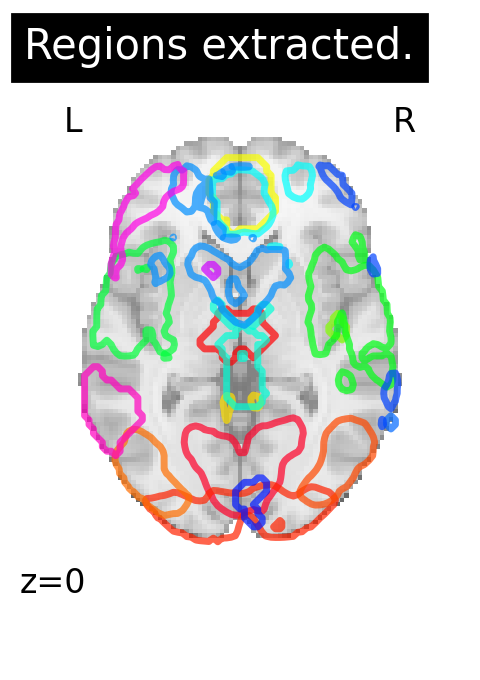

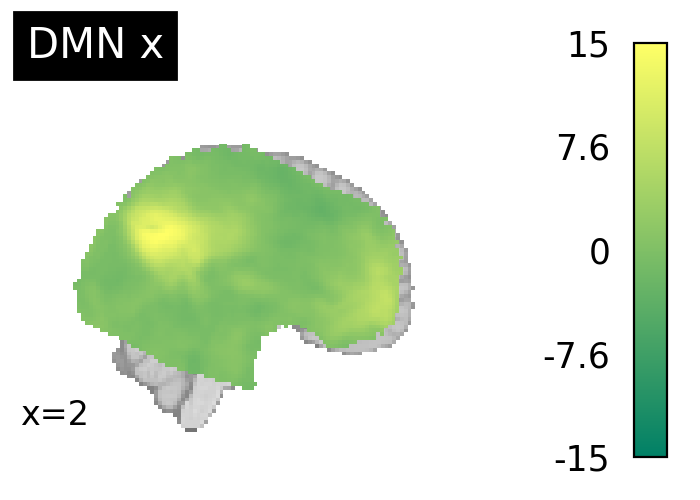

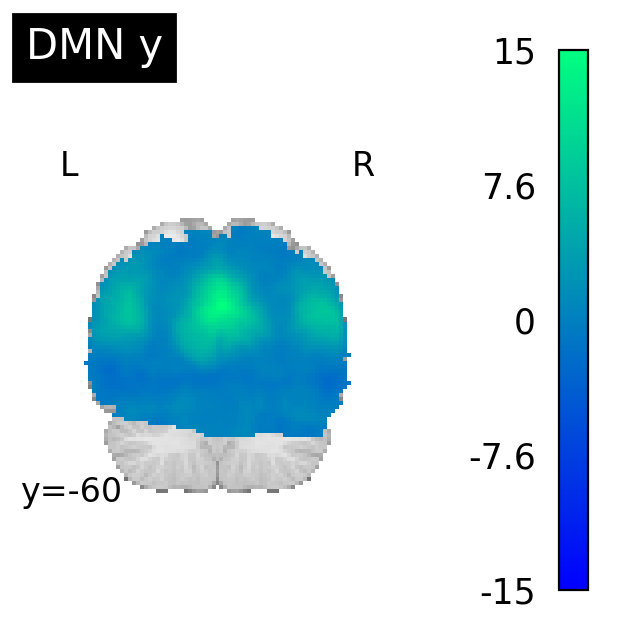

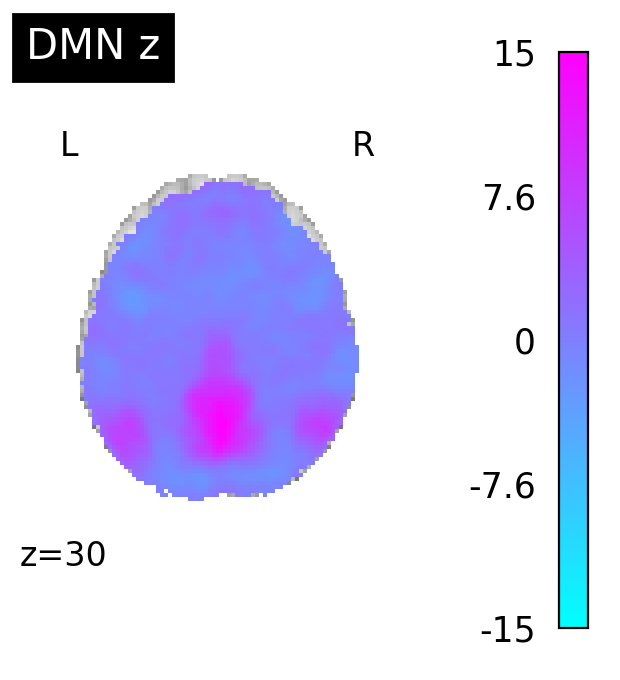

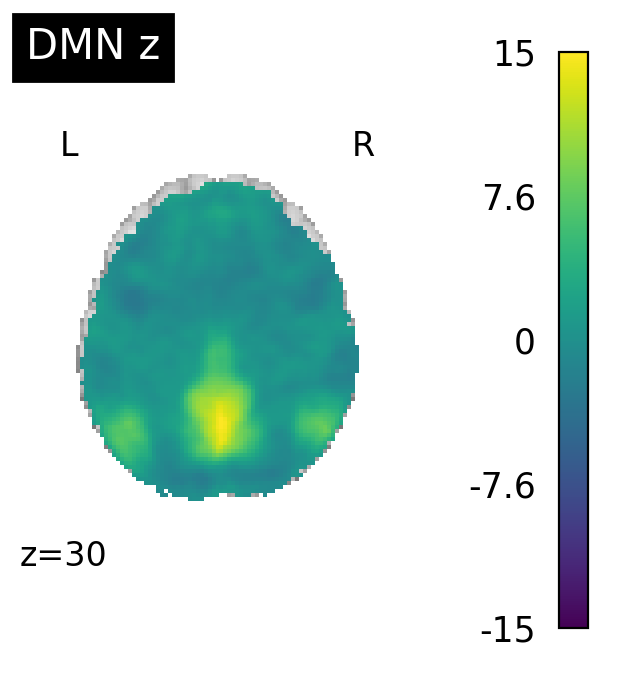

In [ ]:
# Showing region extraction results using 4D maps visualization tool
plotting.plot_prob_atlas(
    regions_img,
    display_mode="z",
    cut_coords=1,
    view_type="contours",
    title="Regions extracted.",
)

# To reduce the complexity, we choose to display all the regions
# extracted from network 3

DMN_network = index_img(atlas_networks, 3)
plotting.plot_stat_map(
    DMN_network,
    display_mode="x",
    cut_coords=1,
    title="DMN x",
    colorbar=True,
    cmap="summer"
)

plotting.plot_stat_map(
    DMN_network,
    display_mode="y",
    cut_coords=1,
    title="DMN y",
    colorbar=True,
    cmap="winter"
)

plotting.plot_stat_map(
    DMN_network,
    display_mode="z",
    cut_coords=1,
    title="DMN z",
    colorbar=True,
    cmap="cool"
)

plotting.plot_stat_map(
    DMN_network,
    display_mode="z",
    cut_coords=1,
    title="DMN z",
    colorbar=True,
    cmap="viridis"
)

plotting.show()

#### Plot...

In [ ]:
# Check the keys in the atlas dictionary
print(atlas.keys())

# Load the region information
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Find indices of parcels corresponding to the DMN (labeled as "Default")
dmn_indices = [i for i, network in enumerate(region_info['network']) if network == 'Default']

# Print the indices
print("Indices of parcels corresponding to the DMN:")
print(dmn_indices)

# Prepare the contrast for visualization
group_contrast = np.zeros(len(region_info['name']))
for idx in dmn_indices:
    group_contrast[idx] = 1  # Set DMN parcels to 1

# Fetch the fsaverage surface
fsaverage = datasets.fetch_surf_fsaverage()

# Assuming the correct keys are found, replace 'labels_L' with the appropriate key
# Prepare the surf_contrast for the left hemisphere
surf_contrast = group_contrast[atlas["labels_L"].astype(int) - 1]

# Visualize the DMN regions on the left hemisphere
view = plotting.view_surf(fsaverage['infl_left'],
                          surf_contrast,
                          vmax=1,
                          cmap='autumn',  # Use a colormap with high contrast
                          title='DMN Regions',
                          symmetric_cmap=False)

# Save the interactive plot to an HTML file in the current directory
output_file = 'dmn_regions.html'
view.save_as_html(output_file)
print(f"Interactive plot saved as {output_file}")


# Display the interactive plot inline (only if the environment supports it)
view

dict_keys(['labels_R', 'labels_L', 'coords'])
Indices of parcels corresponding to the DMN:
[11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]
Interactive plot saved as dmn_regions.html


## Building the GLM and Predicting Gambling Outcome (Win/Loss)

## GLM with both runs

In [ ]:
# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

# Loop through each subject and each run
for subject in subject_ids:
    for run in range(2):  # Assuming there are 2 runs: run 0 and run 1
        timeseries = load_single_timeseries(subject, 'GAMBLING', run)
        evs = load_evs(subject, 'GAMBLING', run)

        for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
            average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
            important_data = average_data[DMN_PARCELS]
            X.append(important_data)
            y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add an intercept
X_scaled = sm.add_constant(X_scaled)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Specify and adapt GLM model
    model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
    results = model.fit()

    # Predictions based on test data
    y_pred_prob = results.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# Calculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')

print(results.summary())

Mean Accuracy: 0.6500
Mean Precision: 0.6580
Mean Recall: 0.6292
Mean F1 Score: 0.6307
Mean ROC AUC: 0.7049
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  360
Model:                            GLM   Df Residuals:                      336
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.76
Date:                Wed, 24 Jul 2024   Deviance:                       393.52
Time:                        08:07:15   Pearson chi2:                     346.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2541
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

## Building the LSTM and Predicting Gambling Outcome (Win/Loss)

#Manu - LSTM with both runs

In [ ]:

# USING THE DMN PARCEL TIMESERIES TO PREDICT GAMBLING OUTCOME (WIN/LOSS)

DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare train data
X = []
y = []

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k-fold cross validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42).split(X_scaled, y)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

accus = []
fprs = []
tprs = []
aucs = []  # AUC values
ppvs = []  # PPV values
npvs = []  # NPV values
senses = []  # Sensitivity values
specs = []  # Specificity values
cms = []  # Confusion Matrices
mean_fpr = np.linspace(0, 1, 100)

cnn_hists = []

for train_idx, test_idx in kf:
    X_train, X_val = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_val = y[train_idx], y[test_idx]

    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Build the LSTM model with increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
    preds_prob = model.predict(X_val).ravel()
    preds = preds_prob.round()

    accus.append(accuracy_score(y_val, preds))

    fpr, tpr, thresholds = roc_curve(y_val, preds_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    aucs.append(auc(fpr, tpr))

    cm = confusion_matrix(y_val, preds)
    cms.append(confusion_matrix(y_val, preds))

    ppv = cm[1, 1] / (cm[1, 1] + cm[0, 1])
    ppvs.append(ppv)

    npv = cm[0, 0] / (cm[0, 0] + cm[1, 0])
    npvs.append(npv)

    sens = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    senses.append(sens)

    spec = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    specs.append(spec)

    train_loss.append(hist.history['loss'])
    train_acc.append(hist.history['accuracy'])
    val_loss.append(hist.history['val_loss'])
    val_acc.append(hist.history['val_accuracy'])

    cnn_hists.append(hist)

print("Avg Accuracy:", np.mean(accus))
print("Avg AUC:", np.mean(aucs))
print("Avg PPV:", np.mean(ppvs))
print("Avg NPV:", np.mean(npvs))
print("Avg Sensitivity:", np.mean(senses))
print("Avg Specificity:", np.mean(specs))




Epoch 1/100
6/6 [==============================] - 7s 198ms/step - loss: 1.9369 - accuracy: 0.5167 - val_loss: 1.8610 - val_accuracy: 0.4500
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 1.8070 - accuracy: 0.6167 - val_loss: 1.7397 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1.6933 - accuracy: 0.6056 - val_loss: 1.6289 - val_accuracy: 0.5500
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 1.5845 - accuracy: 0.6833 - val_loss: 1.5277 - val_accuracy: 0.6500
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 1.4885 - accuracy: 0.6667 - val_loss: 1.4361 - val_accuracy: 0.7000
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 1.4023 - accuracy: 0.6667 - val_loss: 1.3536 - val_accuracy: 0.7000
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 1.3225 - accuracy: 0.6833 - val_loss: 1.2796 - val_accuracy: 0.7000
Epoch 8/100
6/6 [==

1/1 [==============================] - 1s 572ms/step
Epoch 1/100
6/6 [==============================] - 4s 154ms/step - loss: 1.9412 - accuracy: 0.4611 - val_loss: 1.8620 - val_accuracy: 0.4500
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 1.8109 - accuracy: 0.5056 - val_loss: 1.7411 - val_accuracy: 0.4000
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1.6925 - accuracy: 0.5556 - val_loss: 1.6300 - val_accuracy: 0.4000
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 1.5863 - accuracy: 0.6111 - val_loss: 1.5288 - val_accuracy: 0.4000
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 1.4890 - accuracy: 0.6333 - val_loss: 1.4371 - val_accuracy: 0.3500
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 1.3992 - accuracy: 0.6667 - val_loss: 1.3548 - val_accuracy: 0.3500
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 1.3200 - accuracy: 0.6667 - val_lo

1/1 [==============================] - 1s 628ms/step
Epoch 1/100
6/6 [==============================] - 4s 238ms/step - loss: 1.9254 - accuracy: 0.5667 - val_loss: 1.8425 - val_accuracy: 0.7000
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 1.7985 - accuracy: 0.5778 - val_loss: 1.7232 - val_accuracy: 0.7000
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1.6824 - accuracy: 0.6389 - val_loss: 1.6143 - val_accuracy: 0.8500
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 1.5744 - accuracy: 0.6667 - val_loss: 1.5152 - val_accuracy: 0.9000
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 1.4778 - accuracy: 0.7000 - val_loss: 1.4255 - val_accuracy: 0.8500
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 1.3906 - accuracy: 0.7444 - val_loss: 1.3445 - val_accuracy: 0.7500
Epoch 7/100
6/6 [==============================] - 0s 13ms/step - loss: 1.3124 - accuracy: 0.7056 - val_lo

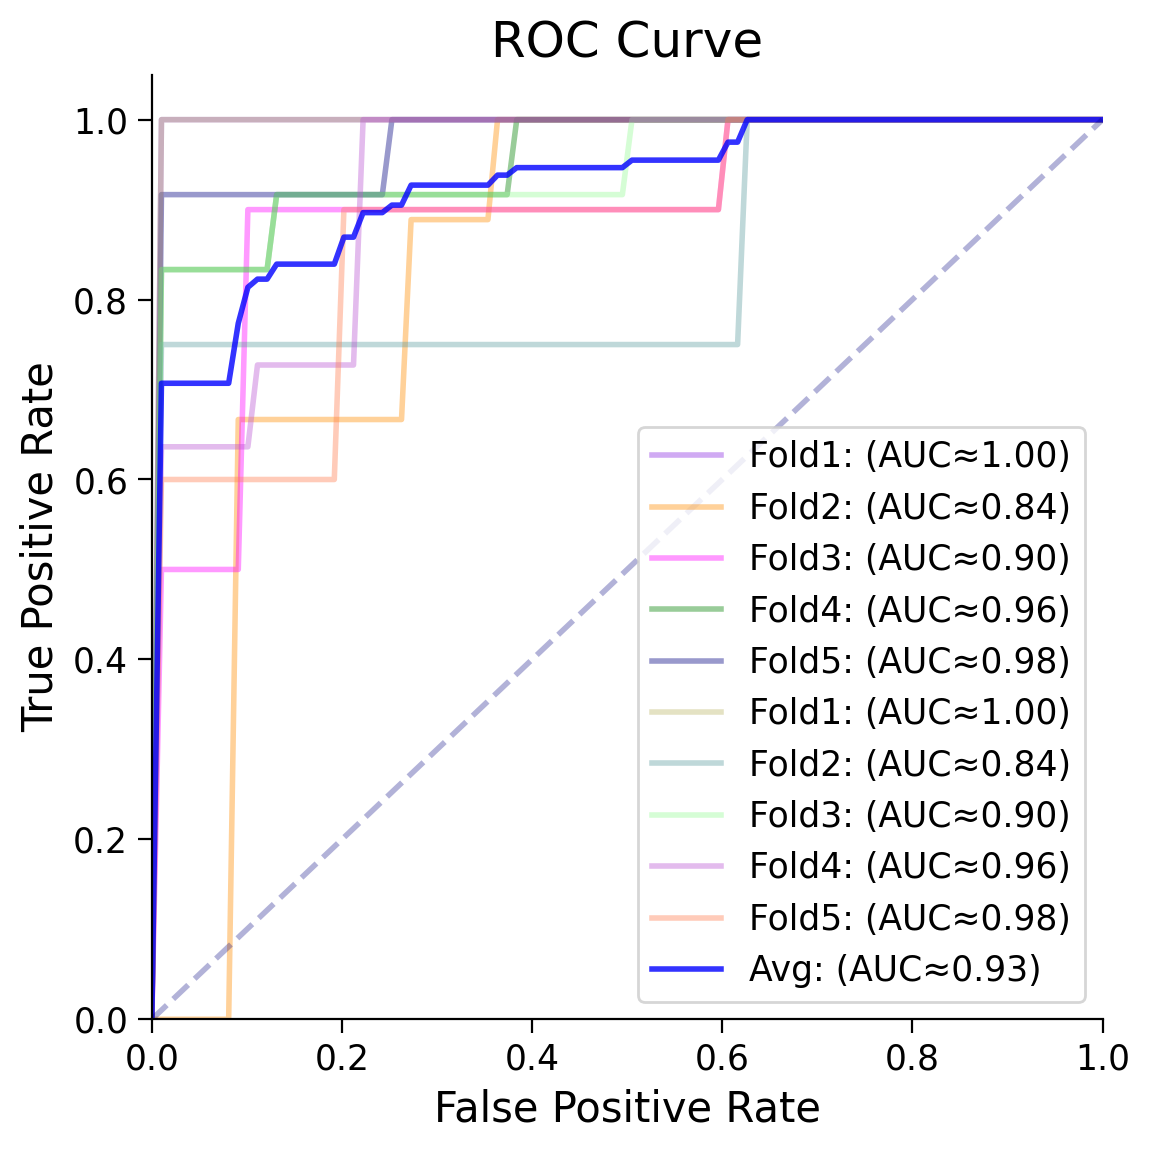

In [ ]:
# ROC Curve
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.figure(figsize=(6, 6))
plt.plot(mean_fpr, tprs[0], color="blueviolet", label=r"Fold1: (AUC≈%0.2f)" % (aucs[0]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[1], color="darkorange", label=r"Fold2: (AUC≈%0.2f)" % (aucs[1]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[2], color="magenta", label=r"Fold3: (AUC≈%0.2f)" % (aucs[2]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[3], color="green", label=r"Fold4: (AUC≈%0.2f)" % (aucs[3]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[4], color="navy", label=r"Fold5: (AUC≈%0.2f)" % (aucs[4]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[5], color="darkkhaki", label=r"Fold1: (AUC≈%0.2f)" % (aucs[0]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[6], color="cadetblue", label=r"Fold2: (AUC≈%0.2f)" % (aucs[1]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[7], color="palegreen", label=r"Fold3: (AUC≈%0.2f)" % (aucs[2]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[8], color="mediumorchid", label=r"Fold4: (AUC≈%0.2f)" % (aucs[3]), lw=2, alpha=.4)
plt.plot(mean_fpr, tprs[9], color="coral", label=r"Fold5: (AUC≈%0.2f)" % (aucs[4]), lw=2, alpha=.4)
plt.plot(mean_fpr, mean_tpr, color="blue", label=r"Avg: (AUC≈%0.2f)" % (mean_auc), lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

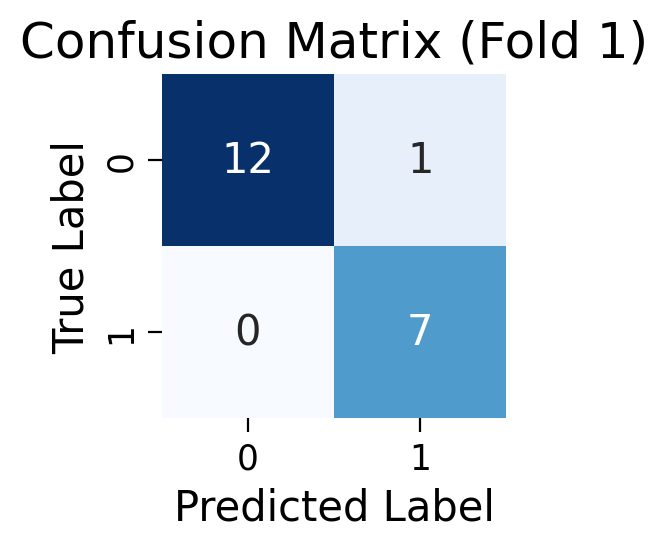

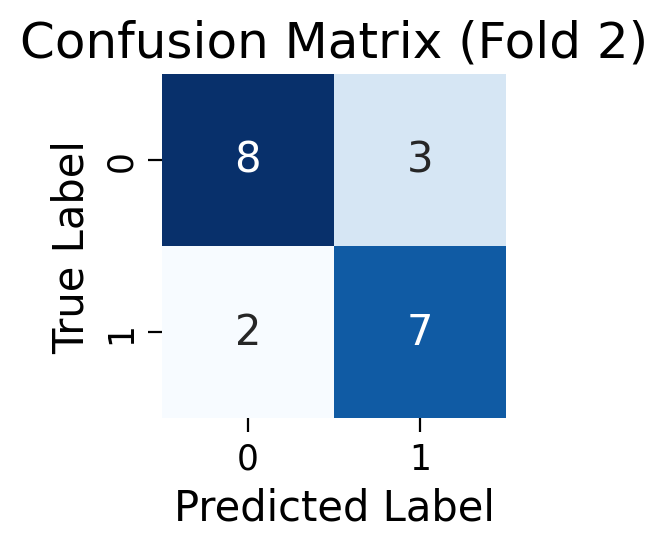

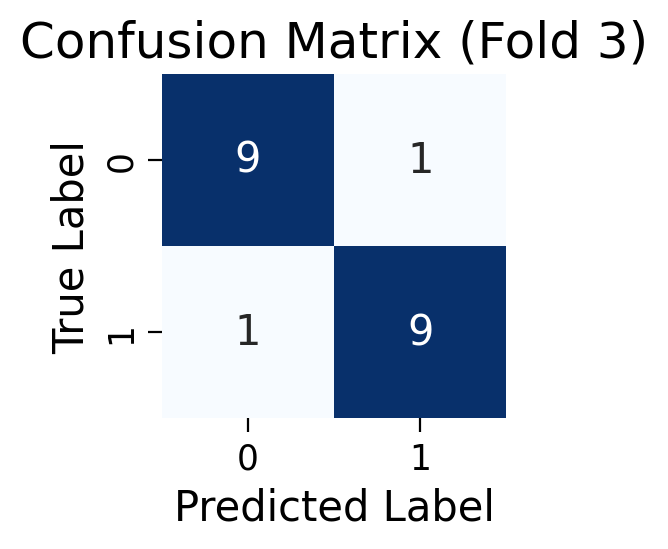

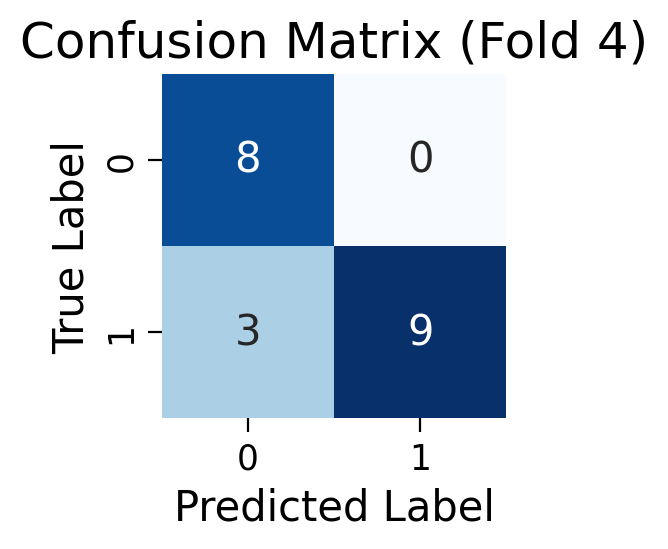

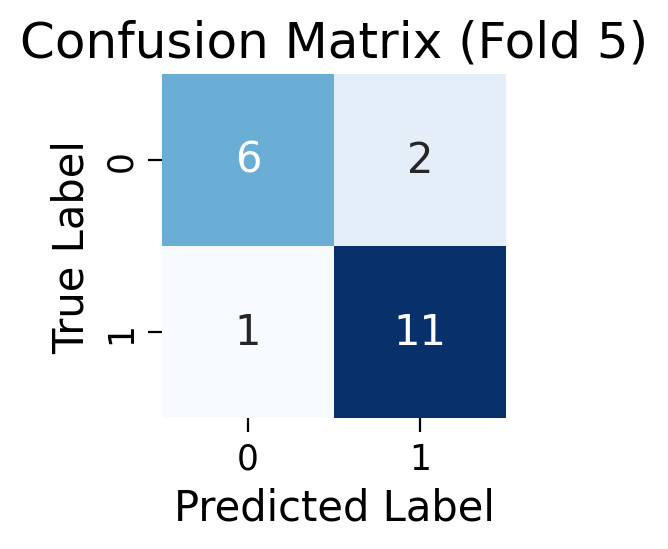

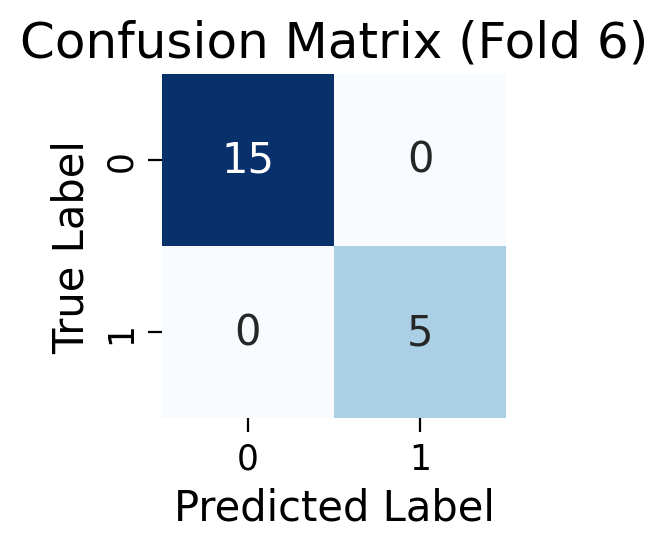

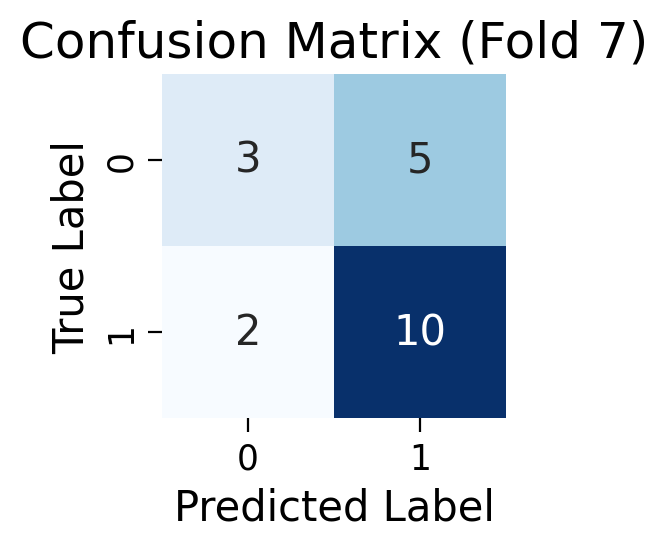

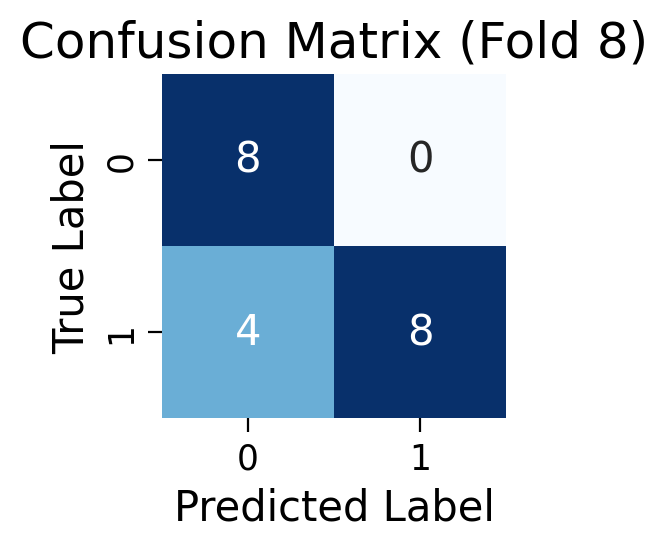

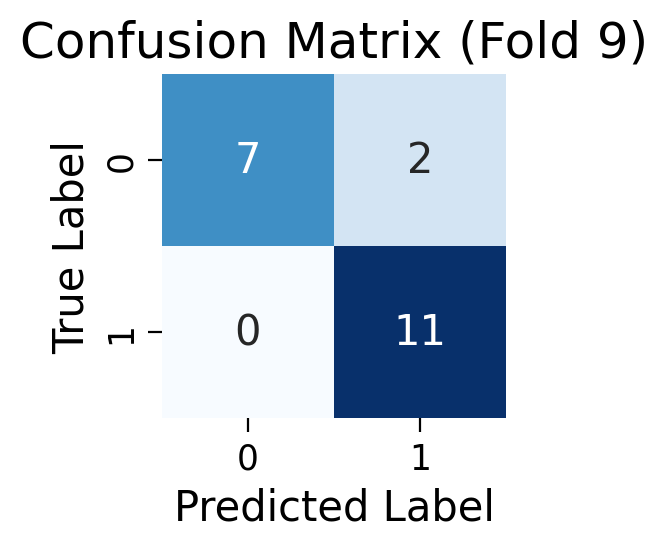

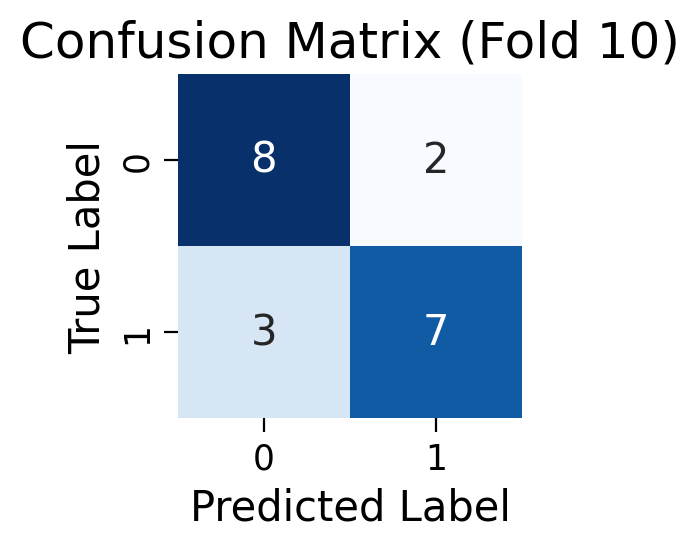

In [ ]:
# Confusion Matrices
plt.figure(figsize=(3, 3))
sns.heatmap(cms[0], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 1)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[1], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 2)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[2], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 3)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[3], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 4)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[4], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 5)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[5], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 6)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[6], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 7)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[7], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 8)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[8], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 9)")
plt.show()

plt.figure(figsize=(3, 3))
sns.heatmap(cms[9], annot=True, fmt='d', cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Fold 10)")
plt.show()

#Manu - GLM + LSTM for both runs

In [ ]:

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model with increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

    # Use LSTM to extract features
    feature_model = Sequential(model.layers[:-1])  # Use all layers except the last Dense layer
    X_train_features = feature_model.predict(X_train_lstm)
    X_test_features = feature_model.predict(X_test_lstm)

    # Reduce dimensionality if necessary (e.g., using PCA)
    # For simplicity, we skip this step in the current code

    # Scale features for GLM
    scaler_features = StandardScaler()
    X_train_features_scaled = scaler_features.fit_transform(X_train_features)
    X_test_features_scaled = scaler_features.transform(X_test_features)

    # Add an intercept for GLM
    X_train_features_scaled = sm.add_constant(X_train_features_scaled)
    X_test_features_scaled = sm.add_constant(X_test_features_scaled)

    # GLM model
    glm_model = sm.GLM(y_train, X_train_features_scaled, family=sm.families.Binomial())
    glm_results = glm_model.fit()

    # Predictions
    y_pred_prob = glm_results.predict(X_test_features_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# Calculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')




Epoch 1/100
6/6 [==============================] - 5s 159ms/step - loss: 1.9611 - accuracy: 0.4753 - val_loss: 1.8664 - val_accuracy: 0.7222
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 1.8312 - accuracy: 0.5309 - val_loss: 1.7463 - val_accuracy: 0.7222
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 1.7116 - accuracy: 0.5988 - val_loss: 1.6365 - val_accuracy: 0.7222
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 1.6058 - accuracy: 0.5802 - val_loss: 1.5370 - val_accuracy: 0.8333
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 1.5089 - accuracy: 0.6790 - val_loss: 1.4463 - val_accuracy: 0.8333
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 1.4214 - accuracy: 0.6667 - val_loss: 1.3641 - val_accuracy: 0.8333
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 1.3456 - accuracy: 0.5741 - val_loss: 1.2903 - val_accuracy: 0.7778
Epoch 8/100
6/6 [==

#Manu: LSTM - PCA for Features - GLM

In [ ]:

import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

# Define DMN parcels
DMN_PARCELS = [11, 24, 25, 27, 73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 191, 205, 254, 258, 302, 304, 308, 318, 351]

# Prepare data
X = []  # Independent variables
y = []  # Dependent variable

for subject in subject_ids:
    timeseries_run0 = load_single_timeseries(subject, 'GAMBLING', 0)
    timeseries_run1 = load_single_timeseries(subject, 'GAMBLING', 1)
    timeseries = np.concatenate((timeseries_run0, timeseries_run1), axis=1)

    evs_run0 = load_evs(subject, 'GAMBLING', 0)
    evs_run1 = load_evs(subject, 'GAMBLING', 1)
    evs = np.concatenate((evs_run0, evs_run1), axis=0)

    for cond_idx, cond in enumerate(EXPERIMENTS['GAMBLING']['cond']):
        average_data = average_frames(timeseries, evs, 'GAMBLING', cond)
        important_data = average_data[DMN_PARCELS]
        X.append(important_data)
        y.append(cond_idx)  # 0 for 'loss', 1 for 'win'

X = np.array(X)
y = np.array(y)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Fold Cross-Validation
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Lists for saving the results
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Build the LSTM model with increased regularization
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    hist = model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

    # Use LSTM to extract features
    feature_model = Sequential(model.layers[:-1])  # Use all layers except the last Dense layer
    X_train_features = feature_model.predict(X_train_lstm)
    X_test_features = feature_model.predict(X_test_lstm)

    # Reduce dimensionality using PCA
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_train_features_pca = pca.fit_transform(X_train_features)
    X_test_features_pca = pca.transform(X_test_features)

    # Scale features for GLM
    scaler_features = StandardScaler()
    X_train_features_scaled = scaler_features.fit_transform(X_train_features_pca)
    X_test_features_scaled = scaler_features.transform(X_test_features_pca)

    # Add an intercept for GLM
    X_train_features_scaled = sm.add_constant(X_train_features_scaled)
    X_test_features_scaled = sm.add_constant(X_test_features_scaled)

    # GLM model
    glm_model = sm.GLM(y_train, X_train_features_scaled, family=sm.families.Binomial())
    glm_results = glm_model.fit()

    # Predictions
    y_pred_prob = glm_results.predict(X_test_features_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred_prob))

# Calculate average metrics
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1_score = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_aucs)

print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Mean Precision: {mean_precision:.4f}')
print(f'Mean Recall: {mean_recall:.4f}')
print(f'Mean F1 Score: {mean_f1_score:.4f}')
print(f'Mean ROC AUC: {mean_roc_auc:.4f}')



Epoch 1/100
6/6 [==============================] - 4s 153ms/step - loss: 1.9514 - accuracy: 0.4630 - val_loss: 1.8639 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 1.8222 - accuracy: 0.5062 - val_loss: 1.7437 - val_accuracy: 0.5000
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 1.7049 - accuracy: 0.5741 - val_loss: 1.6337 - val_accuracy: 0.6111
Epoch 4/100
6/6 [==============================] - 0s 13ms/step - loss: 1.6006 - accuracy: 0.6049 - val_loss: 1.5339 - val_accuracy: 0.6667
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 1.5056 - accuracy: 0.5864 - val_loss: 1.4437 - val_accuracy: 0.7222
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 1.4159 - accuracy: 0.6852 - val_loss: 1.3618 - val_accuracy: 0.7222
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 1.3396 - accuracy: 0.6235 - val_loss: 1.2881 - val_accuracy: 0.7222
Epoch 8/100
6/6 [==